# X Inactivation

In [1]:
import glob
import os
import random
import subprocess

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybedtools as pbt
import seaborn as sns

import cardipspy as cpy
import ciepy

%matplotlib inline

In [2]:
import socket
if socket.gethostname() == 'fl1':
    pbt.set_tempdir('/projects/cdeboever/pybedtools_temp')

In [4]:
outdir = os.path.join(ciepy.root, 'output',
                      'x_inactivation')
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output',
                              'x_inactivation')
cpy.makedir(private_outdir)

In [24]:
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rsem_tpm.tsv')
tpm = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rnaseq_metadata.tsv')
rna_meta = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'subject_metadata.tsv')
subject_meta = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'wgs_metadata.tsv')
wgs_meta = pd.read_table(fn, index_col=0)

gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)

In [6]:
locus_fns = glob.glob(os.path.join(ciepy.root, 'output', 'input_data', 'mbased_locus',
                                   '*_locus.tsv'))
snv_fns = glob.glob(os.path.join(ciepy.root, 'private_output', 'input_data', 'mbased_snv',
                                 '*_snv.tsv'))
count_fns = glob.glob(os.path.join(ciepy.root, 'private_output', 'input_data', 'allele_counts',
                                   '*mbased_input.tsv'))

In [7]:
locus_res = {}
for fn in locus_fns:
    locus_res[os.path.split(fn)[1].split('_')[0]] = pd.read_table(fn, index_col=0)

snv_res = {}
for fn in snv_fns:
    snv_res[os.path.split(fn)[1].split('_')[0]] = pd.read_table(fn, index_col=0)
    
count_res = {}
for fn in count_fns:
    count_res[os.path.split(fn)[1].split('_')[0]] = pd.read_table(fn, index_col=0)

locus_p = pd.Panel(locus_res)
snv_p = pd.Panel(snv_res)

In [51]:
sf = subject_meta[subject_meta.sex == 'F']
meta = sf.merge(rna_meta, left_index=True, right_on='subject_id')
meta = meta.ix[[x for x in snv_p.items if x in meta.index]]

In [95]:
locus_p = locus_p.ix[meta.index]
snv_p = snv_p.ix[meta.index]

In [273]:
# Filter  and take log.
tpm_f = tpm[(tpm != 0).sum(axis=1) > 0]
log_tpm = np.log10(tpm_f + 1)
# Mean center.
log_tpm_c = (log_tpm.T - log_tpm.mean(axis=1)).T
# Variance normalize.
log_tpm_n = (log_tpm_c.T / log_tpm_c.std(axis=1)).T

## Individual Sample

Let's take a look at one sample.

In [295]:
df = locus_res[meta.index[0]]
x = df[gene_info.ix[df.index, 'chrom'] == 'chrX']
notx = df[gene_info.ix[df.index, 'chrom'] != 'chrX']

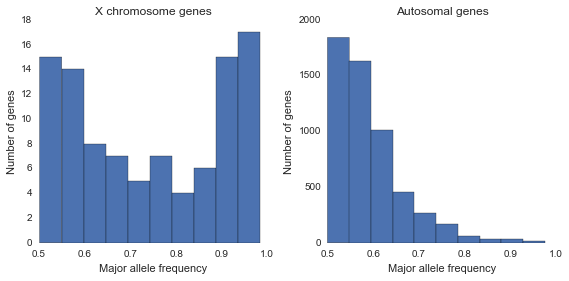

In [296]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
ax = axs[0]
x.major_allele_freq.hist(ax=ax)
ax.set_title('X chromosome genes')
ax.set_ylabel('Number of genes')
ax.set_xlabel('Major allele frequency')
ax = axs[1]
notx.major_allele_freq.hist(ax=ax)
ax.set_title('Autosomal genes')
ax.set_ylabel('Number of genes')
ax.set_xlabel('Major allele frequency')
plt.tight_layout();

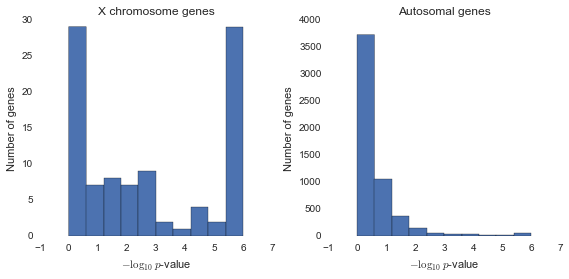

In [297]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
ax = axs[0]
(-np.log10(x.p_val_ase + x.p_val_ase[x.p_val_ase != 0].min())).hist(ax=ax)
ax.set_title('X chromosome genes')
ax.set_ylabel('Number of genes')
ax.set_xlabel('$-\log_{10}$ $p$-value')
ax = axs[1]
(-np.log10(notx.p_val_ase + notx.p_val_ase[notx.p_val_ase != 0].min())).hist(ax=ax)
ax.set_title('Autosomal genes')
ax.set_ylabel('Number of genes')
ax.set_xlabel('$-\log_{10}$ $p$-value')
plt.tight_layout();

## All Samples

In [301]:
t = locus_p.ix[:, :, 'major_allele_freq']
x = t.ix[set(t.index) & set(gene_info[gene_info.chrom == 'chrX'].index)]
notx = t.ix[set(t.index) & set(gene_info[gene_info.chrom != 'chrX'].index)]

In [304]:
x.shape

(456, 128)

In [310]:
?sns.clustermap

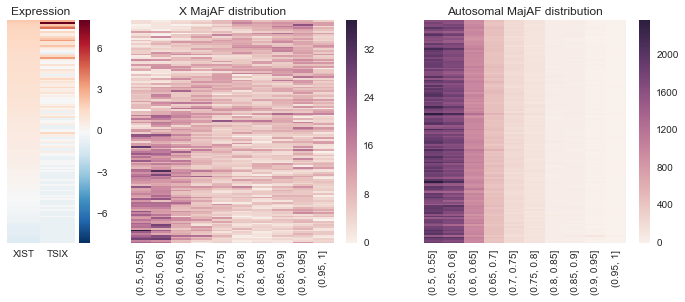

In [324]:
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 3, 3])

ax = plt.subplot(gs[0])
exp = log_tpm_n.ix[[gene_info[gene_info.gene_name == 'XIST'].index[0], 
                    gene_info[gene_info.gene_name == 'TSIX'].index[0]]].T
exp.columns = ['XIST', 'TSIX']
exp = exp.ix[x.columns].sort(columns='XIST', ascending=False)
sns.heatmap(exp, yticklabels=False, ax=ax)
ax.set_ylabel('')
ax.set_title('Expression')

ax = plt.subplot(gs[1])
r = x.apply(lambda z: pd.cut(z[z.isnull() == False], bins=np.arange(0.5, 1.05, 0.05)))
r = r.apply(lambda z: z.value_counts())
sns.heatmap(r.ix[exp.index], yticklabels=False, ax=ax)
ax.set_ylabel('')
ax.set_title('X MajAF distribution')

ax = plt.subplot(gs[2])
r = notx.apply(lambda z: pd.cut(z[z.isnull() == False], bins=np.arange(0.5, 1.05, 0.05)))
r = r.apply(lambda z: z.value_counts())
sns.heatmap(r.ix[exp.index], yticklabels=False, ax=ax)
ax.set_ylabel('')
ax.set_title('Autosomal MajAF distribution');

The X chromosome is clearly enriched for having ASE which is probably due
to incomplete X reactivation. However, only some genes show residual 
inactivation. Are these the same genes across samples?

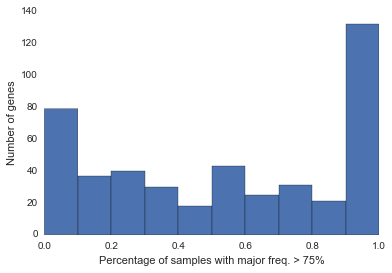

In [120]:
t = locus_p.ix[:, :, 'major_allele_freq']
t = t.ix[set(t.index) & set(gene_info[gene_info.chrom == 'chrX'].index)]
freq = (t[t.isnull() == False] > 0.75).sum(axis=1) / (t.isnull() == False).sum(axis=1)

freq.hist()
plt.ylabel('Number of genes')
plt.xlabel('Percentage of samples with major freq. > 75%');

The above histogram shows what percentage of samples have major
allele frequency greater than 75% for each gene. Note that a gene in a sample is
included here only if it was tested by MBASED for ASE. We can see that
most genes either have all or no samples with major allele frequency
greater than 75%. This suggests that reactivation happens preferentially.
I'd like to build a model that predicts whether reactivation occurs.
I could use the major allele frequency or significant ASE. If I use
significant ASE I can build a logisitic model. I should look into the
X inactivation literature but I imagine some relevant features could be:

* replication timing 
* distance from centromere or telomere 
* XIST binding motif density (does it have a binding motif?)
* distance from X inactivation center
* XIST expression
* TSIX expression

In [338]:
df = pd.read_table('/raid3/projects/CARDIPS/analysis/cardips-ipsc-eqtl/sandbox/RD_sm300_2936763_hFibiPS4p72.txt',
                   low_memory=False, skiprows=15, index_col=0)

In [339]:
df.head()

,Gene_Name,Chromosome,Start_Position,End_Position,Data_Value
ID,,,,,
X1,NaN,chr1,17781,17841,-0.247134
X2,NaN,chr1,30659,30719,-0.240810
X3,NaN,chr1,31123,31183,-0.240594
X4,NaN,chr1,32108,32168,-0.240140
X5,NaN,chr1,36566,36626,-0.238136


In [341]:
df.Chromosome.value_counts()

chr2     183249
chr1     171757
chr3     146506
chr4     139731
chr5     133149
chr6     126695
chr7     118517
chr8     108547
chrX     106458
chr10    102066
chr11     98426
chr12     97812
chr9      91213
chr13     74283
chr14     67627
chr15     61486
chr17     59833
chr16     59590
chr18     58024
chr20     45971
chr19     41242
chr22     26718
chr21     26142
chrY      16637
dtype: int64